# Language Translator 

Translating English to France language using Transformer model.

* The dataset source is www.manythings.org/anki

* Evaluation using BLEU score.

Reference : [Guide to Illustration of Transformer](https://jalammar.github.io/illustrated-transformer/)

### Sequence-to-sequence learning

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input
from tensorflow.keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import sentence_bleu

# Loading the dataset

In [2]:
# text_file = keras.utils.get_file(
#     fname="fra-eng.zip",
#     origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
#     extract=True,
# )
# print(text_file)
# text_file = pathlib.Path(text_file).parent / "fra.txt"
#text_file = '/kaggle/input/french/fra.txt'
text_file = '/kaggle/input/fifty-data/output.txt_fifty'
#text_file = '/kaggle/input/sampling/sample.txt'
#text_file = '/kaggle/input/owndata/output.txt'

Each line contains an English sentence and its corresponding France sentence. The English sentence is the source sequence and France one is the target sequence. We prepend the token "[start]" and we append the token "[end]" to the France sentence.

In [3]:
# #path = "/kaggle/input/sample/sample.txt"
# with open(text_file) as f:
#     lines = f.read().split("\n")[:-1] #[:-1] removes the last line
# text_pairs = []
# #lines is a list now
# for line in lines: 
#     english, french = line.split("\t")
#     french = "[start] " + french + " [end]" 
# #this is to let traformer know when the sentece starts and ends.
#     text_pairs.append((english, french))

Working below

In [4]:
# import pandas as pd

# # Load the CSV file
# csv_file =  '/kaggle/input/en-fr-translation-dataset/en-fr.csv'  # Replace with your actual file path
# data = pd.read_csv(csv_file)

In [5]:
# import csv
# import pandas as pd

# # Load the CSV file
# csv_file =  '/kaggle/input/en-fr-translation-dataset/en-fr.csv'  # Replace with your actual file path
# data = pd.read_csv(csv_file)

# # Define the input CSV file and the output text file paths

# input_csv = csv_file  # Replace with your CSV file path
# output_txt = "output.txt_fifty"  # Output file

# # Maximum number of sentences to process
# max_sentences = 50000

# # Open the CSV file and the output text file
# with open(input_csv, mode='r', encoding='utf-8') as csv_file, open(output_txt, mode='w', encoding='utf-8') as txt_file:
#     csv_reader = csv.reader(csv_file)
    
#     # Skip the header if it exists
#     next(csv_reader, None)
    
#     # Initialize a counter
#     sentence_count = 0
    
#     # Process each row in the CSV
#     for row in csv_reader:
#         if len(row) >= 2:  # Ensure the row has at least two columns
#             english_sentence = row[0]
#             french_sentence = row[1]
            
#             # Write to the output file with tab separation
#             txt_file.write(f"{english_sentence}\t{french_sentence}\n")
            
#             # Increment the counter
#             sentence_count += 1
            
#             # Stop if the maximum number of sentences is reached
#             if sentence_count >= max_sentences:
#                 break

# print(f"Conversion complete! {sentence_count} sentences saved to {output_txt}")


Working above end

In [6]:
# print(text_pairs)

### Printing random English - French text pair

In [7]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, french = line.split("\t")
    french = "[start] " + french + " [end]"
    text_pairs.append((english, french))

In [8]:
import random
#text_pairs = '/kaggle/input/french/fra.txt'
print(random.choice(text_pairs))

("Canada can persist to harness Denmark's high-end technology to enhance Canada's processing of raw materials and boost value-added products.", "[start] Le Canada peut continuer à profiter de la technologie de pointe du Danemark afin d'améliorer ses propres procédés de transformation des matières premières et d'ajouter de la valeur à ses produits. [end]")


In [9]:
import random
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

**Text Cleaning**

In [10]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

**Text Standardization**
* Convert Text to lowercase

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace( 
        lowercase, f"[{re.escape(strip_chars)}]", "")

### Text Vectorization

We'll use two instances of the TextVectorization layer to vectorize the text data (one for English and one for french), that is to say, to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters) and splitting scheme (split on whitespace), while the french layer will use a custom standardization, where we add the character "¿" to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend stripping the punctuation characters in either language. Instead, I would recommend turning each punctuation character into its own token, which you could achieve by providing a custom split function to the TextVectorization layer.

In [12]:
vocab_size = 15000
sequence_length = 20

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_french_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_french_texts)

**Preparing datasets for the translation task**

In [13]:
batch_size = 64

def format_dataset(eng, fre):
    eng = source_vectorization(eng)
    fre = target_vectorization(fre)
    return ({
        "english": eng,
        "french": fre[:, :-1],
    }, fre[:, 1:])

def make_dataset(pairs):
    eng_texts, fre_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    fre_texts = list(fre_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fre_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [14]:
train_ds

<CacheDataset shapes: ({english: (None, 20), french: (None, 20)}, (None, 20)), types: ({english: tf.int64, french: tf.int64}, tf.int64)>

In [15]:
for inputs, targets in train_ds.take(1):
    print(f"english {inputs['english']},\n\n\n inputs['english'].shape: {inputs['english'].shape}")
    print(f"french {inputs['french']},\n\n\n inputs['french'].shape: {inputs['french'].shape}")
    print(f"targets {targets}, \n\n\n targets.shape: {targets.shape}")

english [[ 1259    11     7 ...     0     0     0]
 [    5   421     2 ...     3   280     0]
 [14538     1  7239 ...   435    24    23]
 ...
 [    1    27    43 ...     0     0     0]
 [ 1775     0     0 ...     0     0     0]
 [ 5545     0     0 ...     0     0     0]],


 inputs['english'].shape: (64, 20)
french [[   3  824   38 ...    0    0    0]
 [   3   21  822 ...    8  107  557]
 [   3  100    9 ...  223  113    2]
 ...
 [   3    1   17 ...    0    0    0]
 [   3    1    4 ...    0    0    0]
 [   3 6184    4 ...    0    0    0]],


 inputs['french'].shape: (64, 20)
targets [[ 824   38   22 ...    0    0    0]
 [  21  822    6 ...  107  557 1856]
 [ 100    9 2361 ...  113    2 3702]
 ...
 [   1   17   22 ...    0    0    0]
 [   1    4    0 ...    0    0    0]
 [6184    4    0 ...    0    0    0]], 


 targets.shape: (64, 20)


### Sequence-to-sequence learning with Transformer

### A Transformer for machine translation

## Transformer Encoder

In [16]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = Sequential(
            [Dense(dense_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

#### The Transformer decoder

In [17]:
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [Dense(dense_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.layernorm_3 = LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

### **Positional Embedding layer**

In [18]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = Embedding(
            input_dim=input_dim, output_dim=output_dim)
        print(input_dim,output_dim)
        #intermediate = self.getPositionEncoding(seq_len=input_dim,d=vocab_size,n=output_dim)
        self.position_embeddings = Embedding(input_dim=input_dim, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def getPositionEncoding(self,seq_len, d, n = sequence_length):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        tensor = tf.convert_to_tensor(P)
        print(tensor.shape)
        return tensor
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**End-to-end Transformer**

In [19]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="french")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = Dropout(0.5)(x)
decoder_outputs = Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

15000 256
15000 256


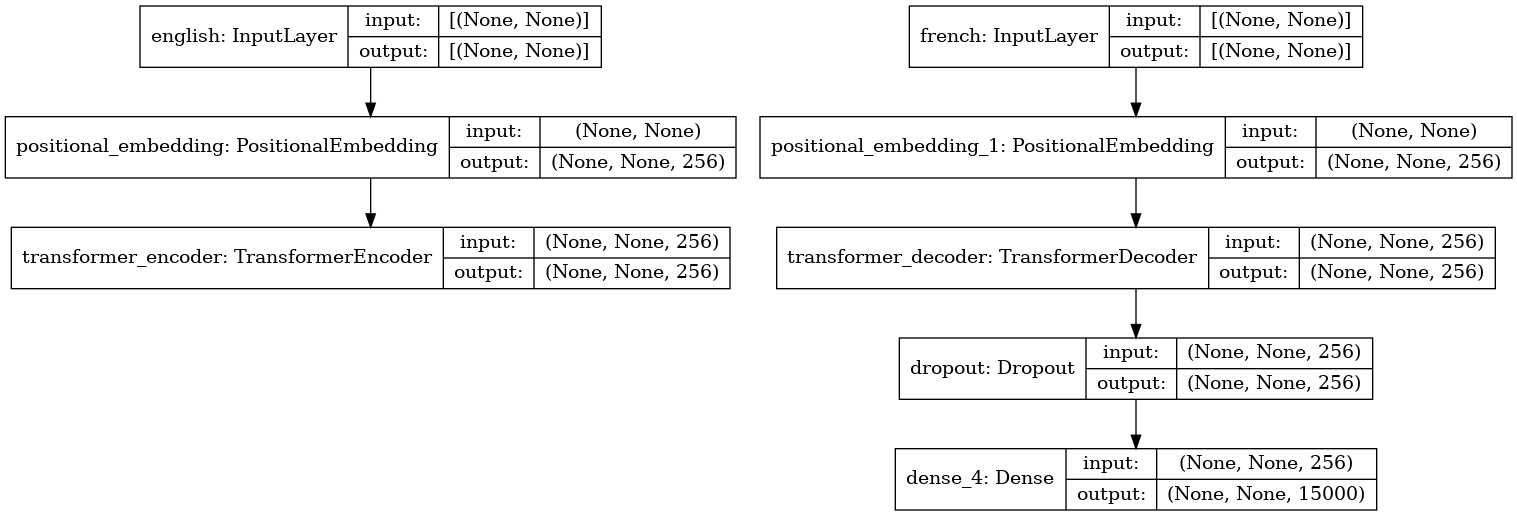

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file='transformer.png', show_shapes=True)
from IPython.display import Image
Image("transformer.png")

**Training the sequence-to-sequence Transformer**

In [21]:
EPOCHS = 1

In [22]:
checkpoint = ModelCheckpoint(filepath='language_translation_checkpoint.hdf5',
                             save_weights_only=True,verbose=1,monitor='val_accuracy')

In [23]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=EPOCHS,callbacks=[checkpoint], validation_data=val_ds)

547/547 [==============================] - 44s 69ms/step - loss: 5.0796 - accuracy: 0.1509 - val_loss: 4.6212 - val_accuracy: 0.1871

Epoch 00001: saving model to language_translation_checkpoint.hdf5


In [24]:
# saving model achitecture in json file
model_json = transformer.to_json()
with open("translator.json", "w") as json_file:
    json_file.write(model_json)

**Translating new sentences with our Transformer model**

In [25]:
fra_vocab = target_vectorization.get_vocabulary()
fra_index_lookup = dict(zip(range(len(fra_vocab)), fra_vocab))
max_decoded_sentence_length = 20

### Output Testing and Decoding the output sequence

In [26]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = fra_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

### Transformer translating output

In [27]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
In 2005, the industry realized a turnover of EUR 3.08 billion with pet food supplies (plus 2.3%).
[start] en 2004 les produits de la croissance de la croissance de la croissance de la croissance de la croissance de
-
The Philippine milk industry is dominated by four major milk processors.
[start] les produits de la demande de la croissance de la plus de la croissance de la croissance de la plus
-
Regulation and marketing of food products is under federal jurisdiction, and overseen by the Ministry of Health and the Ministry of Agriculture.
[start] les produits de la produits de la produits de la production et les produits de la production et les produits
-
ic
[start] [end]
-
Some of the local players have developed separate brands to capture both the AB and CD markets.
[start] les produits que les produits de la demande de la demande de la demande de la production et les produits


# Evaluation using the BLEU score

In [28]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
score = 0
bleu  = 0
for i in range(9):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_fra_texts[i].lower()
    print(candidate,reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu+=score
    print(f"Score:{score}")
print(f"\nBLEU score : {round(bleu,2)}/20")
    

[start] le canada [end] [start] enjeux de nature administrative [end]
Score:0.43478260869565216


/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

[start] les produits de la plus de la plus de la plus de la demande de la plus de la plus [start] les produits sont ensuite livrés aux entrepôts des détaillants qui les distribuent ensuite dans chaque magasin. [end]
Score:0.17977528089887637
[start] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [start] sarah reagh agente de la mesure du rendement agriculture et agroalimentaire canada édifice sir john carling, bureau 737 930, avenue carling ottawa, on k1a 0c5 reaghs@agr.gc.ca [end]
Score:0.05511811023622046
[start] les produits alimentaires de la croissance de la croissance de la croissance de la croissance de la croissance de la [start] il est donc à prévoir que la forte croissance des nutraceutiques observée ces dix dernières années est appelée à se poursuivre. [end]
Score:0.12903225806451615
[start] [UNK] [UNK] [UNK] [UNK] [end] [start] pessimisme dans le secteur  des fleurs coupées (1) [end]
Score:0.2702702702

Epoch 1/30
547/547 [==============================] - 37s 68ms/step - loss: 4.7087 - accuracy: 0.1940 - val_loss: 4.4000 - val_accuracy: 0.2102

Epoch 00001: saving model to language_translation_checkpoint.hdf5
Epoch 2/30
547/547 [==============================] - 37s 68ms/step - loss: 4.5449 - accuracy: 0.2172 - val_loss: 4.2727 - val_accuracy: 0.2277

Epoch 00002: saving model to language_translation_checkpoint.hdf5
Epoch 3/30
547/547 [==============================] - 37s 68ms/step - loss: 4.4088 - accuracy: 0.2350 - val_loss: 4.1824 - val_accuracy: 0.2431

Epoch 00003: saving model to language_translation_checkpoint.hdf5
Epoch 4/30
547/547 [==============================] - 37s 68ms/step - loss: 4.2829 - accuracy: 0.2526 - val_loss: 4.1347 - val_accuracy: 0.2512

Epoch 00004: saving model to language_translation_checkpoint.hdf5
Epoch 5/30
547/547 [==============================] - 37s 68ms/step - loss: 4.1652 - accuracy: 0.2694 - val_loss: 4.1055 - val_accuracy: 0.2619

Epoch 00005

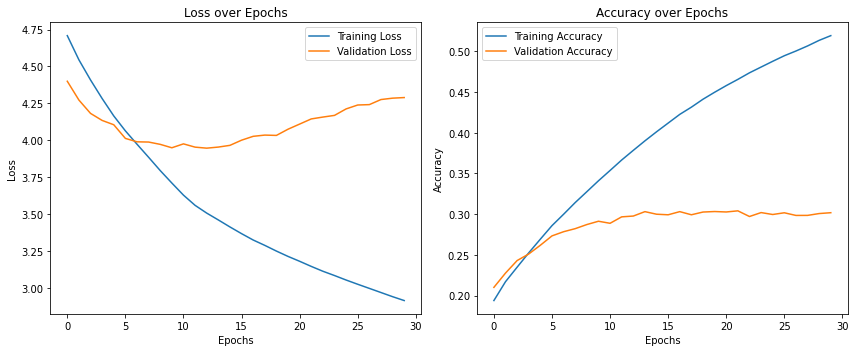

In [29]:
# Train the transformer and store the history
EPOCHS = 30


history = transformer.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint],
    validation_data=val_ds
)

# Extract loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [30]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
bleu = 0

for i in range(9):  # Note: range(10-1) is corrected to range(10) for clarity
    candidate = decode_sequence(test_eng_texts[i])  # Translated text
    reference = test_fra_texts[i].lower()  # Ground truth French text
    english_text = test_eng_texts[i]  # Corresponding English text
    
    # Calculate BLEU score
    score = sentence_bleu([reference.split()], candidate.split(), weights=(1, 0, 0, 0))
    bleu += score
    
    # Print details for each sentence
    print(f"English: {english_text}")
    print(f"Candidate (Translated): {candidate}")
    print(f"Reference (French): {reference}")
    print(f"Score: {score:.2f}\n")

# Calculate overall BLEU score
print(f"\nTotal BLEU score: {round(bleu, 2)}/20")


English: ADMINISTRATIVE ISSUES
Candidate (Translated): [start] [UNK] [UNK] [end]
Reference (French): [start] enjeux de nature administrative [end]
Score: 0.30

English: These products are then delivered to the retailer's platform or warehouses, where they are then distributed to each retail store.
Candidate (Translated): [start] ces produits sont [UNK] [UNK] à ce kiosque de façon de répondre à des entreprises [UNK] après les installations de
Reference (French): [start] les produits sont ensuite livrés aux entrepôts des détaillants qui les distribuent ensuite dans chaque magasin. [end]
Score: 0.24

English: Sarah Reagh Performance Measurement Officer Agriculture and Agri-Food Canada Sir John Carling Building, Room 737 930 Carling Avenue Ottawa, ON K1A 0C5 reaghs@agr.gc.ca
Candidate (Translated): [start] [UNK] [UNK] de la [UNK] food and [UNK] canada avenue carling ottawa commercial ontario de [UNK] avenue de [UNK] avenue carling ottawa
Reference (French): [start] sarah reagh agente de la

In [31]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_fra_texts = [pair[1] for pair in test_pairs]
bleu = 0

# Use the length of test_pairs to avoid index errors
for i in range(10):
    candidate = decode_sequence(test_eng_texts[i])  # Translated text
    reference = test_fra_texts[i].lower()  # Ground truth French text
    english_text = test_eng_texts[i]  # Corresponding English text
    
    # Calculate BLEU score
    score = sentence_bleu([reference.split()], candidate.split(), weights=(1, 0, 0, 0))
    bleu += score
    
    # Print details for each sentence
    print(f"English: {english_text}")
    print(f"Candidate (Translated): {candidate}")
    print(f"Reference (French): {reference}")
    print(f"Score: {score:.2f}\n")

# Calculate overall BLEU score
print(f"\nTotal BLEU score: {round(bleu, 2)}/20")


English: ADMINISTRATIVE ISSUES
Candidate (Translated): [start] [UNK] [UNK] [end]
Reference (French): [start] enjeux de nature administrative [end]
Score: 0.30

English: These products are then delivered to the retailer's platform or warehouses, where they are then distributed to each retail store.
Candidate (Translated): [start] ces produits sont [UNK] [UNK] à ce kiosque de façon de répondre à des entreprises [UNK] après les installations de
Reference (French): [start] les produits sont ensuite livrés aux entrepôts des détaillants qui les distribuent ensuite dans chaque magasin. [end]
Score: 0.24

English: Sarah Reagh Performance Measurement Officer Agriculture and Agri-Food Canada Sir John Carling Building, Room 737 930 Carling Avenue Ottawa, ON K1A 0C5 reaghs@agr.gc.ca
Candidate (Translated): [start] [UNK] [UNK] de la [UNK] food and [UNK] canada avenue carling ottawa commercial ontario de [UNK] avenue de [UNK] avenue carling ottawa
Reference (French): [start] sarah reagh agente de la

## Summary

* Thus Transformer model is implemented for translating English to france.
* BLEU score is the metrics used to evaluate the performance of the tranformer in translating the language.